## Quantiles

Given a probability distribution $f(x)$ (e.g. Gaussian, Binomial, Poisson...) the *cumulative distribution function* (CDF) is defined as 

$$ F(x) = \mathbb{P}(X\le x)\qquad\textrm{or equivalently}\int_{-\infty}^{x}f(x)dx$$

<img src="percentile.png">

The quantile function $Q$, associated with a probability distribution of a random variable, specifies the value  $x$ of the random variable such that the probability $p$ of the variable being less than or equal to that value equals a given probability. It is also called the percent-point function (PPF) or inverse cumulative distribution function

$$Q = F^{-1}\qquad\textrm{returns $x_p$ such that}~F(x_p)\le p$$

In [2]:
# compute ppf and cdf 
from scipy.stats import norm

cdf = norm.cdf(-0.5244)
print(cdf)
print (norm.ppf(0.3))

0.30000017826482295
-0.5244005127080409


The median of a distribution is the 50-percentile (the mean only if the distribution is symmetric).

## Credit curves

Just like a discount curve is a way of representing the underlying interest rates (or equivalently discount factors) implicit in the market quotes of a collection of real-world interest rate products, **credit curves** are a way of representing survival probabilities implied by credit default swaps.

**Credit default swaps** (**CDS**) are instruments whose value depends on the likelihood that a given company (the curve's **issuer**) will suffer a credit event over a given period.

A **credit event** can be a default, the failure to make payments, the issuer entering into bankruptcy proceedings, or the occurence of other legal events. The exact definition of what constitutes a credit event depends on a series of factors and is usually defined in some kind of ISDA (International Swaps and Derivatives Association) master agreement.

In any case, we will generically call a credit event a *default*, and talk about **non-default probabilities** (**NDP**), i.e. the probability that the issuer will not suffer a credit event before a given date i.e. *non-default probability is a cumulative probability* since refers to a time period. 

<table>
  <tr width=200>
    <th>Discount Curve</th>
    <th>Credit Curve</th>
  </tr>
  <tr>
    <td>Represents underlying rates implicit in market quotes of IR products</td>
    <td>Represents default probability implied by credit default swaps</td>
  </tr>
  <tr>
    <td>made of pillar_dates and discount factors</td>
    <td>made of pillar_dates and survival probabilities</td>
  </tr>
  <tr>
    <td>discount factors</td>
    <td>non-default probabilities</td>
  </tr>
  <tr>
    <td>short rate</td>
    <td>hazard rate</td>
  </tr>
</table>   

The short rate, $r_t$, is the interest rate at which an entity can borrow money for an infinitesimally short period of time from time $t$ to $t+dt$.

### Hazard Rate

Hazard rate is often called a *conditional failure rate* since it's expression is a direct
application of the conditional probability concept.

Conditional probability answers to the question "how should you update probabilities of events when there is additional information available ?". To derive the general formula let's start with an example.

A fair die is rolled. Let $A$ be the event that the outcome is an odd number ($A={1,3,5}$). Also let $B$ be the event that the outcome is less than or equal to $3$ ($B={1,2,3}$). What is the probability of $A$ ($\mathbb{P}(A)$) ? What is the probability of $A$ given $B$ ($\mathbb{P}(A|B)$) ?

Being a simple example we can compute the result by hand:

$$\mathbb{P}(A) = \cfrac{|A|}{|S|} = \cfrac{|\{1,3,5\}|}{6} = \cfrac{1}{2}\qquad\textrm{(where $S$ is the entire sample space)}$$

Now let's find the conditional probability of $A$ given that $B$ occurred. If we know $B$ has occurred, the outcome must be among $\{1,2,3\}$. For $A$ to also happen the outcome must be in $A\cap B = \{1,3\}$. Since all die rolls are equally likely, we argue that $\mathbb{P}(A|B)$ must be equal to

$$\mathbb{P}(A|B) = \cfrac{|A\cap B|}{|B|} = \cfrac{2}{3}$$

To generalize our example we can rewrite the calculation by dividing the numerator and denominator by the entire space of the events $|S|$ hence:

$$\mathbb{P}(A|B) = \cfrac{|A\cap B|}{|B|} = \cfrac{\cfrac{|A\cap B|}{|S|}}{\cfrac{|B|}{|S|}} = \cfrac{\mathbb{P}(A\cap B)}{\mathbb{P}(B)}$$

<img src="conditional_b.png" width=500>

Hazard rate represents the instantaneous probability of the issuer defaulting *conditioned* on it not having defaulted until that moment.

In formula if the default (survival) probability is indicated by $DP$ ($N$), the hazard rate by $\lambda$ and the time of default with $\tau$:

$$\lambda(t) = \cfrac{\mathbb{P}(A\cap B)}{\mathbb{P}(B)} = \cfrac{DP(\tau \in (t, t+dt))}{DP(\tau\gt t)} = \cfrac{\cfrac{d(DP)}{dt}}{N(t_0, t)} = \cfrac{\cfrac{d(1-N)}{dt}}{N(t_0, t)} = -\cfrac{dN}{dt}\cfrac{1}{N(t_0, t)}$$

where the minus sign derives from the fact that $N$ is a **non** default probability while the hazard rate is defined in terms of the probability of default $DP$.

In practice we will calculate it numerically, and therefore it'll be the (annualized) conditional probability of the issuer defaulting between the value date and the day after.
Conversely given the hazard rate the survival probability can be determined as:

$$\lambda(t) = -\cfrac{1}{dt}\cdot\cfrac{dN}{N} = -\cfrac{d(\textrm{log}N)}{dt}$$

$$N(t_0, t) = e^{-\int_{t_0}^{t}\lambda(s) ds}$$

### CreditCurve class

In [1]:
# implement CreditCurve class
import math, numpy
from dateutil.relativedelta import relativedelta

class CreditCurve:
    def __init__(self, pillars, ndps):
        self.pillars = pillars
        self.ndps = ndps
        self.pillar_days = [(p-self.pillars[0]).days for p in self.pillars]
        
    def ndp(self, d):
        d = (d - self.pillars[0]).days
        return (numpy.interp(d, self.pillar_days, self.ndps))

    def hazard_rate(self, d):
        ndp_1 = self.ndp(d - relativedelta(days=1))
        ndp_2 = self.ndp(d)
        dt = 1/365.
        l = -(ndp_2 - ndp_1)/dt/self.ndp(d)
        return l

As usual we test the newly developed class with some dummy data.

In [2]:
# set observation_date and CreditCurve
from datetime import date

observation_date = date.today()
cc = CreditCurve([observation_date, observation_date+relativedelta(years=2)],
                 [1, 0.8])

In [3]:
# check ndp in 1 year
cc.ndp(observation_date+relativedelta(years=1))


0.9

In [4]:
# check hazard in 1 year
cc.hazard_rate(observation_date+relativedelta(years=1))

0.11111111111112416

## Credit Deafult Swaps

Once we have implemented a $\tt{CreditCurve}$ class which allows us to interpolate survival probabilities, and also to calculate the hazard rate at arbitrary dates, we can use it to price **credit default swaps** (CDSs).

A CDS is a financial swap agreement that the seller of the CDS will compensate the buyer in the event of a debt default or other credit event. That is, the seller of the CDS insures the buyer against some reference asset defaulting. The buyer of the CDS makes a series of payments (the CDS "fee" or "spread") to the seller and, in exchange, may expect to receive a payoff if the asset defaults. 

CDSs are made up of two legs:

* the *default* leg: which pays $LGD = F(1 - R)$, known as the **loss given default**, if and when the credit event occurs, $F$ is the face value of the contact, $R$ is the recovery rate (usually set around 40%);
* the *premium* leg: which pays the *spread* $S$ every m months until the credit event occurs.

### Premium leg

Let's start with the premium leg. We will use the following notation:

* $d$ today's date;
* $d_0$ the start date of the CDS (could be different from $d$);
* $d_1, ..., d_n$ the payment dates of the premium leg, which occur at a m-month frequency (we assume that $d_n$ is the end date of the CDS);
* $D(d')$ the discount factor between $d$ and $d'$;
* $N(d')$ the survival probability between $d$ and $d'$;
* $\tau$ the random variable representing the date of the credit event.

At each payment date $d_i$, a flow $F\cdot S$ is paid if and only if the credit event has not occurred before that date. Since the NPV depends on the default probability, the value of the premium leg can be estimated by an expectation

$$f_{\textrm{premium}}^i = \mathbb{E}\left[ S \times D(d_i) \times \mathbb{1}(\tau > d_i) \right]$$

where $\mathbb{1}(\tau > d_i)$ means that the expectation value has to be evaluated when $\tau > d_i$. Remember that if $x$ is a random variable with a finite number of finite outcomes $x_{1},x_{2},\ldots ,x_{k}$ occurring with probabilities $p_{1},p_{2},\ldots ,p_{k}$ respectively, the expectation of $x$ is:

$$\mathbb{E}[x] = \sum _{i=1}^{k}x_{i}\,p_{i}=x_{1}p_{1}+x_{2}p_{2}+\cdots +x_{k}p_{k}$$
which is the weighted sum of the $x_i$, with $p_{i}$ values being the weights. 

In our case $x_i = S\cdot D(d_i)$ and $p_i=N(d_i)$ so the NPV of the leg can be expressed as:

$$\textrm{NPV}_{premium} = F\cdot S\cdot \sum_{i=1}^{n} D(d_i) \cdot N(d_i)$$

## Default leg

The LGD is paid out on the same date on which the credit event occurs, i.e. it can potentially be paid out on any date between $d_0$ and $d_n$. Mathematically, therefore, the NPV of the premium leg can be expressed as follows:

$$\mathrm{NPV_{default}} = \mathbb{E} \left[F(1-R) \times D(\tau) \times \mathbb{1}(\tau \leq d_n) \right] $$

Using the laws of probability, we can break this down into the sum of "daily NPVs" calculated as a function of the daily default probabilities $DP$:

$$
\begin{align*}
\mathbb{E}\left[F(1-R) \times D(\tau) \times \mathbb{1}(\tau \leq d_n) \right]
&= \sum_{d'=d_0}^{d_n} \mathbb{E}[ F(1-R) \times D(\tau) | \tau = d'] DP[ \tau = d' ] \\
&= F(1-R) \sum_{d'=d_0}^{d_n} D(d') \left( DP[ \tau \geq d' ] - DP[ \tau \geq d'+1 ] \right) \\
&= F(1-R) \sum_{d'=d_0}^{d_n} D(d') \left( N(d') - N(d'+1) \right)
\end{align*}
$$

where the last step holds since $DP[\tau\geq d'] = 1 - DP[\tau < d'] = 1 - (1-N(\tau < d')) = N(\tau < d')$.

<img src="timeline.png">

In [1]:
# credit default swap class with breakeven method
from finmarkets import generate_dates

class CreditDefaultSwap:
    def __init__(self, notional, start_date, spread, maturity, tenor=3, recovery=0.4):
        self.notional = notional
        self.spread = spread
        self.start_date = start_date
        self.payment_dates = generate_dates(start_date, maturity*12, tenor)
        self.recovery = recovery
    
    def npv_premium(self, dc, cc):
        v = 0
        for i in range(1, len(self.payment_dates)):
            v += dc.df(self.payment_dates[i]) * cc.ndp(self.payment_dates[i])
            
        return self.notional * self.spread * v
    
    def npv_default(self, dc, cc):
        d = self.payment_dates[0]
        v = 0
        while d <= self.payment_dates[-1]:
            v += dc.df(d)*(cc.ndp(d) - cc.ndp(d+relativedelta(days=1)))
            d += relativedelta(days=1)        
        return self.notional*(1-self.recovery)*v
            
    def npv(self, dc, cc):
        return self.npv_default(dc, cc) - self.npv_premium(dc, cc)
    
    def breakeven_rate(self, dc, cc):
        num = self.npv_default(dc, cc)
        den = self.npv_premium(dc, cc) / self.spread
        return num/den

Below a simple test of the class, using [discount_curve_ch_10.xlsx](https://drive.google.com/file/d/1mugHyet3H9tcSAvYvt8G4_kpfaEbVY7b/view?usp=sharing).

In [31]:
import pandas as pd
from finmarkets import DiscountCurve, CreditCurve
from dateutil.relativedelta import relativedelta
from datetime import date

start_date = date(2020, 11, 4)
dc_data = pd.read_excel('discount_curve_ch_10.xlsx')
dc_data['pillars'] = dc_data['pillars'].dt.date
dc_data.dropna(subset=['pillars'], inplace=True)

dc = DiscountCurve(start_date, 
                   dc_data['pillars'],
                   dc_data['discount_factors'].tolist())

credit_curve = CreditCurve([start_date, 
                            start_date + relativedelta(months=36)], 
                           [1.0, 0.7])

cds = CreditDefaultSwap(1e6, start_date, 0.03, 3)

In [30]:
# check default leg, premium leg and npv
print (cds.npv_premium(dc, credit_curve))
print (cds.npv_default(dc, credit_curve))
print (cds.npv(dc, credit_curve))
print (cds.breakeven_rate(dc, credit_curve))

299867.86539770674
180844.13223595402
-119023.73316175272
0.018092381989257694


## Estimate Default Probabilities from CDS

Pretty much like the discount curves could be derived from OIS market quotes, we can estimate default probabilities (hence credit curves) from CDS quotes using *bootstrap*.
Following the same steps seen for the discount curve we can determine default probabilites at discrete dates to fill our curve:

* collect market quotes for a number of CDS with different maturities;
* create the corresponding CDS objects;
* define a $\tt{CreditCurve}$ whose pillars are the CDS maturity dates and the survival probabilities are unknown;
* define an objective function to minimize the sum of the squared CDS's NPVs;
* set the non-default probabilities to an initial value and define their range of variability between $[0, 1]$ since they are probabilities and fix "today's" probability to 1 since there hasn't been any default;
* run the minimization.

The file for market quotes is [cds_quotes.xlsx](https://drive.google.com/file/d/1BOtwCFYk0CUwYkMhnowWTj0HNOpBefd_/view?usp=sharing).


In [32]:
# bootstrapping
from scipy.optimize import minimize

import pandas as pd
quotes = pd.read_excel("cds_quotes.xlsx")
print (quotes.head())

pillars = [start_date]
cdss = []
for i in range(len(quotes)):
    cds = CreditDefaultSwap(1, start_date, quotes['quote'][i],
                           quotes['months'][i]//12)
    cdss.append(cds)
    pillars.append(cds.payment_dates[-1])

def objective_function(x):
    cc = CreditCurve(pillars, x)
    
    s = 0
    for c in cdss:
        s += c.npv(dc, cc)**2
    return s

bounds = [(0,1) for _ in range(len(pillars))]
x0 = [0.1 for _ in range(len(pillars))]
bounds[0] = (1,1)

res = minimize(objective_function, x0, bounds=bounds)

   months    quote
0      12  0.01469
1      24  0.01650
2      36  0.01730
3      72  0.01820
4     120  0.01830


In [33]:
print (res)

      fun: 1.5631087068777117e-11
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.50174114e-06,  2.28813890e-06, -2.46120241e-06, -2.07817681e-07,
        3.48982754e-06, -8.13928577e-07,  1.66483400e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 96
      nit: 10
   status: 0
  success: True
        x: array([1.        , 0.90802097, 0.80398767, 0.70870175, 0.48274049,
       0.29639829, 0.08653125])


### Determine Default Probabilities from Bond Prices

The price of a bond issued by a party is directly linked to the credit rating of that party, since there is always an associated default risk, which means that the borrower might not be able to repay fully or partially the amount of the taken loan.
Bonds with low ratings, called junk bonds, are sold at lower prices (since riskier) while those with higher ratings, called investment-grade bonds, are sold at higher prices.

Let's see with an example how the default probability can be determined from bond prices.
Imagine to have a bond and let $x$ represent the present value of a bond cash flow stream. 

When you have a default probability associated to the issuer to valuate the bond we need to take each possible value of $x$, multiply it by its probability and sum the results. In other words the value of the bond should equal the mathematical expectation of $x$.

Consider a bond which pays $F$ at maturity and that the issuer of this bond has a default probability $DP$ (in case of default the recovery is $R$).What will be the price of this bond ?

$$ V_{bond} =
\begin{cases}
& D \cdot R \cdot F\quad\textrm{(in case of default of the issuer)}\\
&D \cdot F\quad\textrm{(in case of no default)}\\
\end{cases}$$
where $D$ is the proper discount factor.
Since we don’t know if the issuer will default or not we can estimate the bond price as

$$V_{bond} = D \cdot R \cdot F \cdot DP ( \tau ) + D \cdot F \cdot ( 1 − DP ( \tau)) = D\cdot F \cdot ( 1 − ( 1 − R ) DP ( \tau ))$$

From the this equation is clear that the higher the default probability the lower is the bond price. Conversely, given the market price of the bond we can estimate the issuer default probability.

In the notes there is a generalization of this formula to estimate the default probability of a bond issuer from its current price

$$\mathbb{E}(x) = \Big(CSD + RF(1-S)\Big)\cfrac{1-(SD)^N}{1-SD}+F(SD)^N$$
where $C$ the coupon and $N$ their number, $F$ the bond face value, $R$ the recovery percentage and $S$ the survival probability between two coupons. 

With $\mathbb{E}(x)$ equal to the price of the bond, this equation can be solved numerically for $S$. The default probability is simply $(1-S)$, and the probability that the bond defaults anytime within the next $k$ coupons is $(1-S^k)$.

Consider for example a bond with 4 year maturity, a face value of €100 which provides 5% yearly coupons. Also the recovery rate $R$ is 40% and the risk-free rate is constant a 3%. Let's try to estimate the default probability of the issuer of this bond, finding from the previous equation the value of $S$ which give the current trading price (€80).

In [35]:
# with brentq determine default probability
from scipy.optimize import brentq

N = 4
F = 100
C = 0.05
R = 0.4
r = 0.03
D = 1/(1+r)
trading_price = 80

def func(S):
    return (C*S*D + R*F*(1-S))*(1-(S*D)**N)/(1-S*D) + F*(S*D)**N-trading_price

S = brentq(func, 0, 1)
print (1-S)

0.04797066237531611


In [39]:
(1-S**N)

0.17851180472805073

In [14]:
from scipy.stats import multivariate_normal, norm
import numpy as np

C1 = np.array([0.065, 0.146, 0.218, 0.282, 0.341])
C2 = np.array([0.238, 0.390, 0.503, 0.595, 0.667])

for c in C1:
    print ("{} -> {:.4f}".format(c, norm.ppf(c)))
print ("")
for c in C2:
    print ("{} -> {:.4f}".format(c, norm.ppf(c)))

g = multivariate_normal(mean=[0,0],
                        cov=[[1, 0.4],
                             [0.4, 1]])

print (g.cdf([-1.5141, -0.7128]))

0.065 -> -1.5141
0.146 -> -1.0537
0.218 -> -0.7790
0.282 -> -0.5769
0.341 -> -0.4097

0.238 -> -0.7128
0.39 -> -0.2793
0.503 -> 0.0075
0.595 -> 0.2404
0.667 -> 0.4316
0.03435364791840133


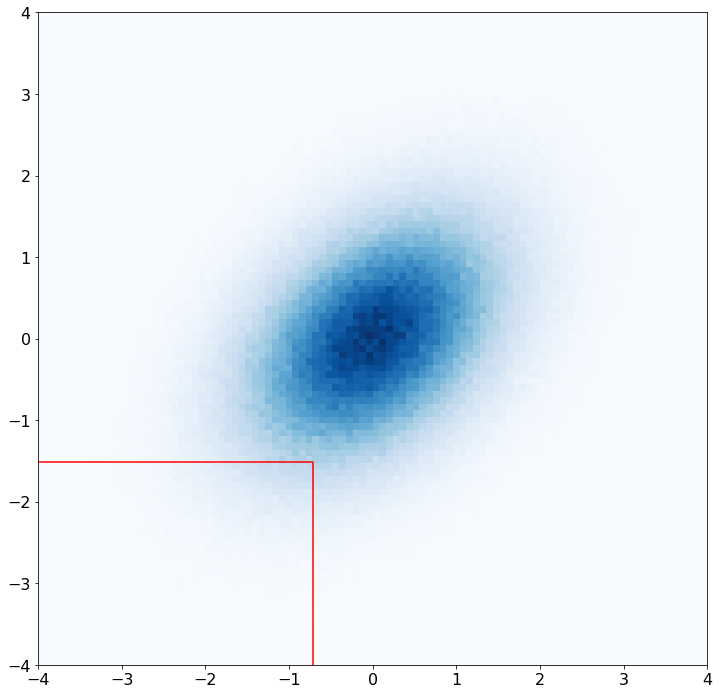

In [39]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib import cm

rcParams['figure.figsize'] = (12, 12)
rcParams['font.size'] = 16
x = g.rvs(size=1000000)
plt.hist2d(x[:,0], x[:,1], range=[[-4, 4], [-4, 4]], bins=(100, 100), cmap=plt.get_cmap("Blues"))
plt.hlines(-1.5141, -4, -0.7128, color='red')
plt.vlines(-0.7128, -4, -1.5141, color='red')
plt.show()